### 가위바위보 이미지 분류 using ResNet101

In [1]:
# Google drive mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch import optim
from torch.optim.lr_scheduler import StepLR
from torch.optim import lr_scheduler

# dataset and transformation
import torchvision
from torchvision import datasets, models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os
from PIL import Image

# display images
from torchvision import utils
import matplotlib.pyplot as plt
%matplotlib inline

# utils
import numpy as np
from torchsummary import summary
import time
import copy
from tqdm.notebook import tqdm

In [3]:
# data load
train_dir = os.path.join("/content/drive/MyDrive/Colab Notebooks/DeepLearning_6024/train")

# class path 
train_rock_dir = os.path.join(train_dir, "rock")
train_scissors_dir = os.path.join(train_dir, "scissors")
train_paper_dir = os.path.join(train_dir, "paper")

In [4]:
train_rock_file = os.listdir(train_rock_dir)
train_scissors_file = os.listdir(train_scissors_dir)
train_paper_file = os.listdir(train_paper_dir)
print('# of rock images:', len(train_rock_file))
print('# of scissors images:', len(train_scissors_file))
print('# of paper images:', len(train_paper_file))

# of rock images: 1026
# of scissors images: 1020
# of paper images: 1026


In [5]:
# load image folder & data
transform = {
    'train': transforms.Compose([
                                transforms.RandomResizedCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                               ]),
    'val': transforms.Compose([
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                               ])
}

train_image_dataset = {x: datasets.ImageFolder(train_dir, transform=transform[x]) for x in ['train', 'val']}
data_loader = {x: torch.utils.data.DataLoader(
    train_image_dataset[x], batch_size=32, shuffle=True, num_workers=2, drop_last=True) for x in ['train', 'val']}
dataset_sizes = {x: len(train_image_dataset[x]) for x in ['train', 'val']}

In [6]:
# setting "gpu" device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


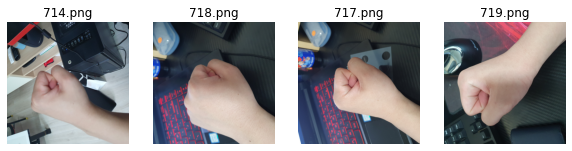

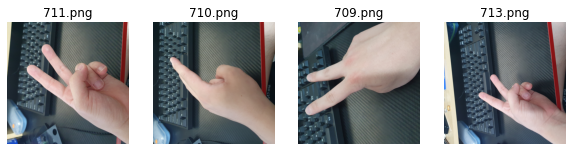

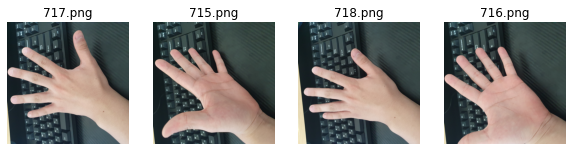

In [8]:
# show image
train_rock_image = [os.path.join(train_rock_dir, fname)
                   for fname in train_rock_file]
train_scissors_image = [os.path.join(train_scissors_dir, fname)
                   for fname in train_scissors_file]
train_paper_image = [os.path.join(train_paper_dir, fname)
                   for fname in train_paper_file]

def show_image(nrows, ncols, data_path):
    plt.figure(figsize=(10,10))
    for i in range(nrows*ncols):
        plt.subplot(nrows,ncols,i+1)
        plt.imshow(Image.open(data_path[i]))
        plt.title(data_path[i].split('/')[-1])
        plt.axis('off')
    plt.show()

nrows, ncols = 1, 4
show_image(nrows, ncols, train_rock_image)
show_image(nrows, ncols, train_scissors_image)
show_image(nrows, ncols, train_paper_image )

In [7]:
def train_model(model, criterion, optimizer, num_epochs=10): #scheduler,
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict()) # 그냥가져오면 reference가 되므로 복제
    best_acc = 0.0
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() # Set model to training mode
            else:
                model.eval() # Set model to evaluate mode
            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            for inputs, labels in data_loader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
            # zero the parameter gradients
                optimizer.zero_grad()
            # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
            # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
            # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            # if phase == 'train':
            #     scheduler.step()
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model  # early stopping
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    model.load_state_dict(best_model_wts)
    return model

In [8]:
# hyperparameter
lr =  0.1e-2
batch_size = 32
num_epoch = 10

In [16]:
########################## 처음 모델을 만들때만 사용 ############################
# pretrained 모델을 가져와 FC layer만 unfreeze
model_conv = models.resnet101(pretrained=True) 

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 3)

model_conv = model_conv.to(device)

## Loss function
criterion = nn.CrossEntropyLoss()

# optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=lr, momentum=0.9)
optimizer_conv = optim.Adam(model_conv.fc.parameters(), lr=lr)

# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=10, gamma=0.1)

In [12]:
## 파라미터 불러와 학습하기
model_conv = models.resnet101(pretrained=False)
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 3)

model_conv.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/DeepLearning_6024/resnet101_2.pt"))

model_conv = model_conv.to(device)

if torch.cuda.is_available():
    model_conv.cuda()

## Loss function
criterion = nn.CrossEntropyLoss()


optimizer_conv = optim.Adam(model_conv.fc.parameters(), lr=lr)

In [10]:
from torchsummary import summary

summary(model_conv, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [13]:
model_ft = train_model(model_conv, criterion, optimizer_conv,  num_epochs=num_epoch) # exp_lr_scheduler,

Epoch 0/9
----------
train Loss: 0.5534 Acc: 0.7887
val Loss: 0.3499 Acc: 0.8952

Epoch 1/9
----------
train Loss: 0.4589 Acc: 0.8311
val Loss: 0.3795 Acc: 0.8594

Epoch 2/9
----------
train Loss: 0.4570 Acc: 0.8184
val Loss: 0.3014 Acc: 0.8936

Epoch 3/9
----------
train Loss: 0.4304 Acc: 0.8320
val Loss: 0.2890 Acc: 0.9059

Epoch 4/9
----------
train Loss: 0.4177 Acc: 0.8372
val Loss: 0.2836 Acc: 0.9004

Epoch 5/9
----------
train Loss: 0.4312 Acc: 0.8288
val Loss: 0.3241 Acc: 0.8828

Epoch 6/9
----------
train Loss: 0.4147 Acc: 0.8330
val Loss: 0.2928 Acc: 0.8841

Epoch 7/9
----------
train Loss: 0.3887 Acc: 0.8464
val Loss: 0.2815 Acc: 0.8900

Epoch 8/9
----------
train Loss: 0.3840 Acc: 0.8496
val Loss: 0.3057 Acc: 0.8740

Epoch 9/9
----------
train Loss: 0.3656 Acc: 0.8571
val Loss: 0.2631 Acc: 0.8962

Training complete in 19m 8s
Best val Acc: 0.905924


In [14]:
torch.save(model_ft.state_dict(), "/content/drive/MyDrive/Colab Notebooks/DeepLearning_6024/resnet101_3.pt")